* https://uniswapv3book.com/index.html
* https://medium.com/@chaisomsri96/defi-math-uniswap-v3-concentrated-liquidity-bd87686b3ecf
* https://liobaheimbach.github.io/assets/pdf/Papers/Risks_and_Returns_of_Uniswap_V3_Liquidity_Providers.pdf
* https://docs.uniswap.org/sdk/v3/guides/advanced/active-liquidity
* https://blog.uniswap.org/uniswap-v3-math-primer
* https://blog.uniswap.org/uniswap-v3-math-primer-2
* https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf

In [56]:
from uniswappy import *
import pandas as pd
import copy
import matplotlib.pyplot as plt

user_nm = MockAddress().apply()
eth_amount = 10000
tkn_amount = 100000

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]
lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

In [57]:
def get_current_liquidity(lp, user, positions):
    _id = UniV3Utils.getPositionKey(user, lwr_tick, upr_tick)
    if(_id in positions):
        return positions[_id].liquidity
    else:
        return 0
        
def update_graph(lp, user, tkn, positions, graph):
    curr = get_current_liquidity(lp, user, positions)
    delta_liq = get_current_liquidity(lp, user, lp.positions) - curr
    #print(f'curr {curr}')
    if not user in graph:
        graph[user_add] = {} 
        graph[user_add]['price'] = lp.get_price(tkn)
        graph[user_add]['lwr_tick'] = lwr_tick
        graph[user_add]['upr_tick'] = upr_tick
        graph[user_add]['delta_liq'] = delta_liq
    else:  
        graph[user_add]['price'] = lp.get_price(tkn)
        graph[user_add]['lwr_tick'] = lwr_tick
        graph[user_add]['upr_tick'] = upr_tick
        graph[user_add]['delta_liq'] += delta_liq        


In [58]:
n_steps = 50
start_price = eth_amount/tkn_amount
mu = 0.1; sigma = 0.5
n_paths = 1

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

accounts = MockAddress().apply(250)

Text(0.5, 0, 'Date')

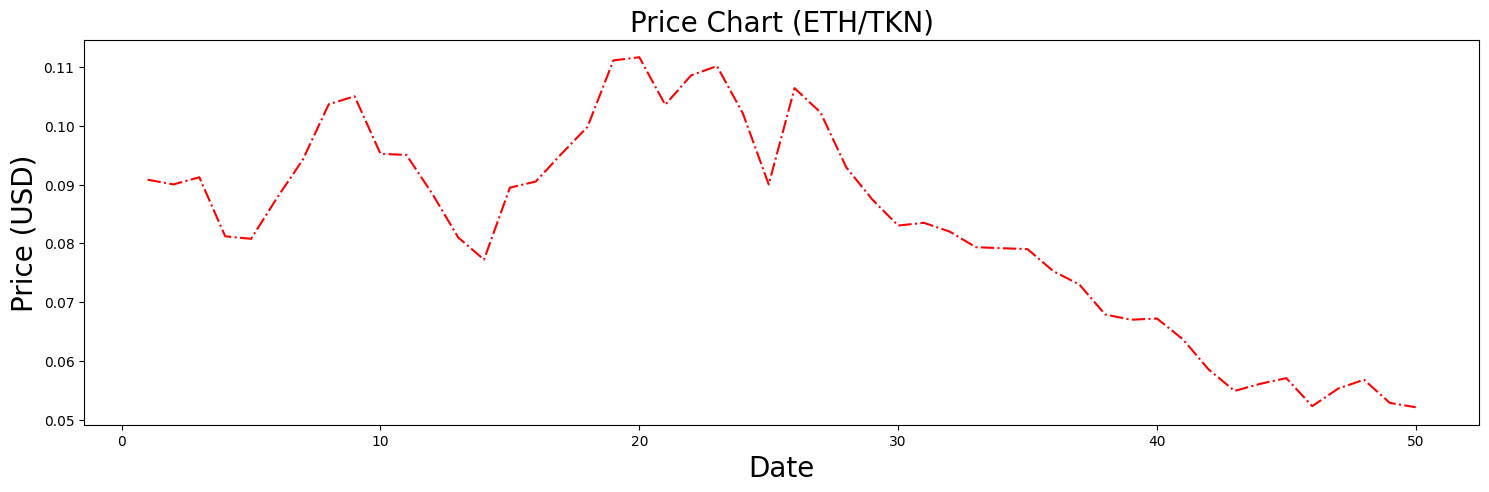

In [59]:
x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(x_val[1:], p_arr[1:], color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_title(f'Price Chart (ETH/TKN)', fontsize=20)
USD_ax.set_ylabel('Price (USD)', size=20)
USD_ax.set_xlabel('Date', size=20)

In [60]:
tkn = ERC20("TKN", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

Join().apply(lp, user_nm, eth_amount, tkn_amount)
lp.summary()

df_v2 = pd.DataFrame(columns = ['price', 'liq'])

Exchange ETH-TKN (LP)
Reserves: ETH = 10000, TKN = 100000
Liquidity: 31622.776601683792 



In [61]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_swap_amt = TokenDeltaModel(30).delta()
    rnd_add_amt = TokenDeltaModel(30).delta()

    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)

    # Random trade volume  
    if(select_tkn == 0):
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt)
        df_v2 = pd.concat([df_v2,pd.DataFrame.from_dict({'price': [lp.get_price(tkn)], 'liq': [lp.last_liquidity_deposit]})])
        out = Swap().apply(lp, eth, user_nm, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt)
        df_v2 = pd.concat([df_v2,pd.DataFrame.from_dict({'price': [lp.get_price(tkn)], 'liq': [lp.last_liquidity_deposit]})])
        out = Swap().apply(lp, tkn, user_nm,  p*rnd_swap_amt)  
        
    
    print(f'Market: {exp_p_arr[k]}, LP: {lp.get_price(tkn)}')

print('')
lp.summary()

Market: 0.0908177023935847, LP: 0.09056571880642116
Market: 0.09002216101724372, LP: 0.09003977214542144
Market: 0.09123337078393226, LP: 0.09110940628072087
Market: 0.08118494127067356, LP: 0.0813722666820475
Market: 0.08076186761337537, LP: 0.08074698684649056
Market: 0.08771754983979026, LP: 0.08779447506214648
Market: 0.09424077666470522, LP: 0.09425964413207315
Market: 0.1036651818267242, LP: 0.10365331652153502
Market: 0.10502158708484786, LP: 0.10537751952466527
Market: 0.09522712317074243, LP: 0.09496806936740256
Market: 0.09504623827885059, LP: 0.09531856269929263
Market: 0.0884423388878079, LP: 0.08841137082318055
Market: 0.08100031598605202, LP: 0.08121387039029969
Market: 0.07722046392724985, LP: 0.07729549375155562
Market: 0.08946999238999111, LP: 0.08942399417184811
Market: 0.09050821123320558, LP: 0.0905875905882754
Market: 0.0952597760627863, LP: 0.09519071542866463
Market: 0.0998224212498712, LP: 0.0998346590201148
Market: 0.1111331665928474, LP: 0.11073385697385019
Ma

In [62]:
df_v2.sort_values(by=['price'], inplace=True)
df_v2.reset_index(drop=True,inplace=True)
df_v2['price'] = np.round(df_v2['price'].values, 3)
freq_df_v2 = df_v2.groupby('price').agg({'liq': 'sum'})

In [84]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

#lwr_tick = lp.get_tick_price(-1, 10, 5000)
#upr_tick = lp.get_tick_price(1, 10, 5000)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

SwapDeposit().apply(lp,  eth,  user_nm, 100, lwr_tick, upr_tick)
lp.summary()

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9999.999999999998, TKN = 100000.0
Gross Liquidity: 31622.776601683792 

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 10099.999253728402, TKN = 100000.0
Gross Liquidity: 31780.26022877525 



In [76]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

#lwr_tick = lp.get_tick_price(-1, 10, 5000)
#upr_tick = lp.get_tick_price(1, 10, 5000)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9999.999999999998, TKN = 100000.0
Gross Liquidity: 31622.776601683792 



In [77]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p, lwr_tick, upr_tick)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_swap_amt = TokenDeltaModel(30).delta()
    rnd_add_amt = TokenDeltaModel(30).delta()
    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)
    #v3_positions = copy.deepcopy(lp.positions)

    lwr_tick = lp.get_tick_price(-1, lp.get_price(eth), 1000)
    upr_tick = lp.get_tick_price(1, lp.get_price(eth), 1000)
    
    if(select_tkn == 0): 
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt, lwr_tick, upr_tick)
        #update_graph(lp, user_add, tkn, v3_positions, v3_graph)
        #out = Swap().apply(lp, eth, user_swap, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt, lwr_tick, upr_tick)
        #update_graph(lp, user_add, tkn, v3_positions, v3_graph)
        #out = Swap().apply(lp, tkn, user_swap,  p*rnd_swap_amt) 

    print(f'Market: {exp_p_arr[k]}, LP: {lp.get_price(tkn)}')

print('')
lp.summary()

Market: 0.0908177023935847, LP: 0.09083068679167983
Market: 0.09002216101724372, LP: 0.08777254805618515
Market: 0.09123337078393226, LP: 0.09117512523328422
Market: 0.08118494127067356, LP: 0.08096100425609727
Market: 0.08076186761337537, LP: 0.08171176750493038
Market: 0.08771754983979026, LP: 0.08757657448199185
Market: 0.09424077666470522, LP: 0.0928382542211214
Market: 0.1036651818267242, LP: 0.10453634612962207
Market: 0.10502158708484786, LP: 0.10399342559756475
Market: 0.09522712317074243, LP: 0.09320879448177595
Market: 0.09504623827885059, LP: 0.0979150429627732
Market: 0.0884423388878079, LP: 0.08964514108182105
Market: 0.08100031598605202, LP: 0.08068700516685344
Market: 0.07722046392724985, LP: 0.07598190670935086
Market: 0.08946999238999111, LP: 0.09072546395879685
Market: 0.09050821123320558, LP: 0.08877644097090998
Market: 0.0952597760627863, LP: 0.09450240628044261
Market: 0.0998224212498712, LP: 0.10058907700551227
Market: 0.1111331665928474, LP: 0.11417399088341296
M

In [75]:
lp.ticks

{-887220: TickInfo(liquidityGross=31657190351886216200000, liquidityNet=31657190351886216200000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 887220: TickInfo(liquidityGross=31657190351886216200000, liquidityNet=-31657190351886216200000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 22980: TickInfo(liquidityGross=1675558047560466493000, liquidityNet=1426121857115578691000, feeGrowthOutside0X128=66497826915057733775513357251689500, feeGrowthOutside1X128=779966364559461154249311806367831190),
 24960: TickInfo(liquidityGross=1633042853484257149100, liquidityNet=-1633042853484257149100, feeGrowthOutside0X128=177474531007594133798353315005881486, feeGrowthOutside1X128=2162735376643903292357023957801357062),
 22680: TickInfo(liquidityGross=615902517182756944000, liquidityNet=615902517182756944000, feeGrowthOutside0X128=52823886054386313115669336634270346, feeGrowthOutside1X128=599992276378373367904103245828987116),
 24660: TickInfo(liquidityGross=91964445124519121000, liquidityN

In [ ]:
def calc_Lx(dx, lwr_tick, upr_tick):
    pa_sqrt_human = TickMath.getSqrtRatioAtTick(lwr_tick)/2**96
    pb_sqrt_human = TickMath.getSqrtRatioAtTick(upr_tick)/2**96 
    p_sqrt_human = math.sqrt(10)
    Lx = dx/(1/p_sqrt_human - 1/pb_sqrt_human)
    return Lx

def calc_Ly(dy, lwr_tick, upr_tick):
    pa_sqrt_human = TickMath.getSqrtRatioAtTick(lwr_tick)/2**96
    pb_sqrt_human = TickMath.getSqrtRatioAtTick(upr_tick)/2**96 
    p_sqrt_human = math.sqrt(10)
    Ly = 1000/(p_sqrt_human - pa_sqrt_human)
    return Ly

In [55]:
for k, pos in enumerate(v3_graph):
    row = np.empty(2)
    row[0] = v3_graph[pos]['price']
    row[1] = v3_graph[pos]['delta_liq']/10**18
    res = row if k == 0 else np.vstack((res, row))

df = pd.DataFrame(res, columns = ['price', 'liq'])
df.sort_values(by=['price'], inplace=True)
df.reset_index(drop=True,inplace=True)
df['price'] = np.round(df['price'].values, 3)
freq_df_v3 = df.groupby('price').agg({'liq': 'sum'})

NameError: name 'v3_graph' is not defined

In [ ]:
fig, (price_ax, ld_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(12, 10))

price_ax.plot(x_val[1:], p_arr[1:], color = 'r',linestyle = 'dashdot', label='initial invest') 
price_ax.set_title(f'Price Chart (ETH/TKN)', fontsize=15)
price_ax.set_ylabel('Price (USD)', size=14)
price_ax.set_xlabel('Date', size=10)

ld_ax.axvline(x = lp.get_price(tkn), color = 'red', linestyle = 'dashdot', linewidth=2, label = 'Last Price')
ld_ax.bar(freq_df_v2.index, freq_df_v2['liq'].values, color ='purple', width = 0.00095, alpha = .5, label = 'Uni V2')
ld_ax.bar(freq_df_v3.index, freq_df_v3['liq'].values, color ='teal', width = 0.00095, alpha = .5, label = 'Uni V3')
ld_ax.set_title('Liquidity Frequency Distribution: Uniswap V2 vs V3',fontsize=15)
ld_ax.set_ylabel('Liquidity', fontsize=14)
ld_ax.set_xlabel('Price (USD)', fontsize=10)
ld_ax.legend()